In [20]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib

matplotlib.rcParams['figure.figsize'] = [15,15]
# matplotlib.rcParams['axis=none']

In [21]:
# def crop_mask(im, y):
#         ny, nx = im.shape
#         y,x = np.mgrid[0:nx,0:ny]
#         r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
#         return ( (r < rcirc))

def detect_line_segments(cropped_edges):
    # tuning min_threshold, minLineLength, maxLineGap is a trial and error process by hand
    rho = 1  # distance precision in pixel, i.e. 1 pixel
    angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
    min_threshold = 10  # minimal of votes
    line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold, 
                                    np.array([]), minLineLength=8, maxLineGap=4)

    return line_segments

def make_points(frame, line):
    height, width, _ = frame.shape
    slope, intercept = line
    y1 = height  # bottom of the frame
    y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

    # bound the coordinates within the frame
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]

def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        # logging.info('No line_segment segments detected')
        return lane_lines

    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    boundary = 1/3
    left_region_boundary = width * (1 - boundary)  # left lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary # right lane line segment should be on left 2/3 of the screen

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                # logging.info('skipping vertical line segment (slope=inf): %s' % line_segment)
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    if len(left_fit) > 0:
        lane_lines.append(make_points(frame, left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)
    if len(right_fit) > 0:
        lane_lines.append(make_points(frame, right_fit_average))

    # logging.debug('lane lines: %s' % lane_lines)  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

    return lane_lines


def display_lines(frame, lines, line_color=(0, 255, 0), line_width=2):
    line_image = np.zeros_like(frame)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
    line_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    return line_image

In [22]:
img = cv2.imread('cam.jpg')
edges = cv2.Canny(img,100, 150)
# np.shape(img)

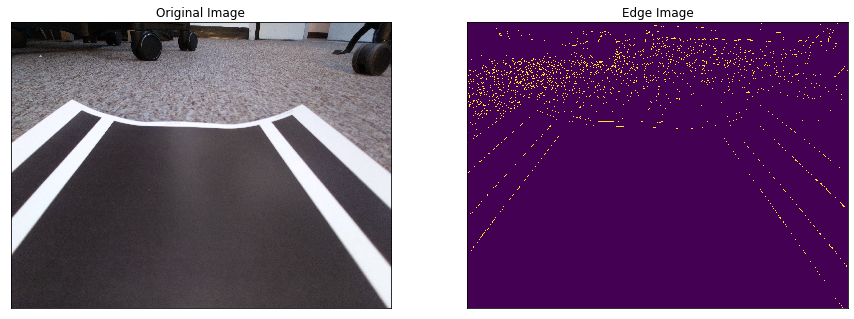

In [23]:
# plt.figure(figsize=(10,10))
plt.subplot(121)
im1 = plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122)
im2 = plt.imshow(edges)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [24]:
white = [[220,220,220],[255,255,255]]
orange = [255,165,0]

In [25]:
lower = np.array(white[0])
upper = np.array(white[1])

In [26]:
mask = cv2.inRange(img,lower,upper)
output = cv2.bitwise_and(img,img,mask = mask)
cv2.imwrite('images.jpg', output)

True

In [27]:
img3 = cv2.imread('images.jpg')
edge2 = cv2.Canny(img3,1,1000)

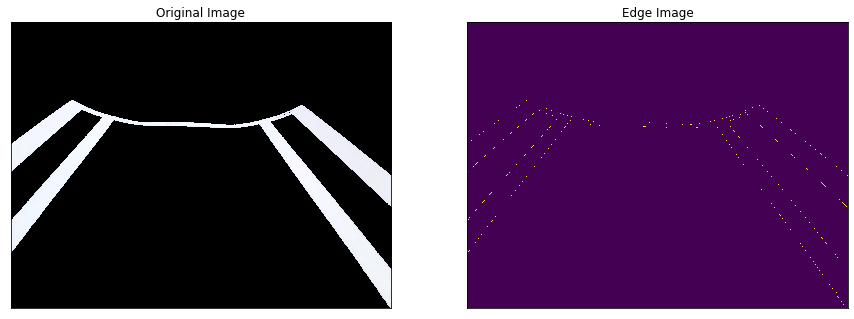

In [28]:
plt.subplot(121)
im1 = plt.imshow(img3)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122)
im2 = plt.imshow(edge2)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [29]:
img_curve = cv2.imread('curve.jpg')
edge_curve = cv2.Canny(img_curve, 100,150)

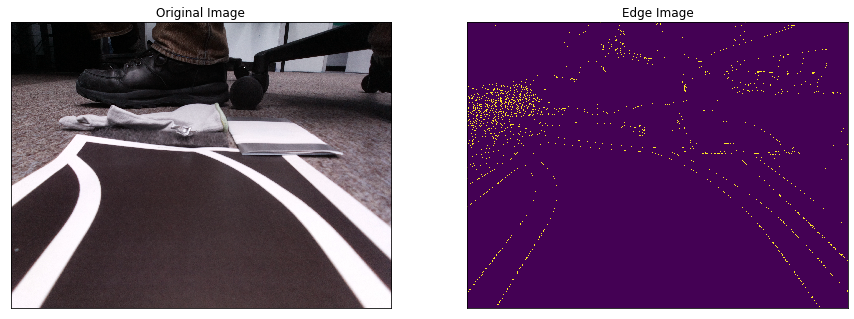

In [30]:
plt.subplot(121)
im1 = plt.imshow(img_curve)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122)
im2 = plt.imshow(edge_curve)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [31]:
mask_curve = cv2.inRange(img_curve,lower,upper)
output_curve = cv2.bitwise_and(img_curve,img_curve,mask = mask)
cv2.imwrite('images.jpg', output_curve)


mask = cv2.inRange(img_curve,lower,upper)
output = cv2.bitwise_and(img_curve,img_curve,mask = mask)
cv2.imwrite('images_curved.jpg', output)

True

In [32]:
reduced_image = cv2.imread('images_curved.jpg')
curved_reduced_edge = cv2.Canny(reduced_image,50,200)



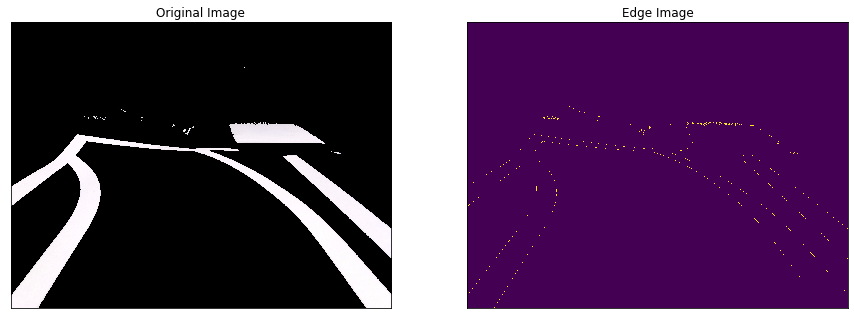

In [33]:
plt.subplot(121)
im1 = plt.imshow(reduced_image)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122)
im2 = plt.imshow(curved_reduced_edge)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [34]:
lane = detect_line_segments(edge2)

In [35]:
lane.shape

(405, 1, 4)

In [36]:
lane

array([[[2986, 1774, 3267, 2121]],

       [[2345, 1177, 2441, 1313]],

       [[2542, 1235, 2721, 1449]],

       ...,

       [[ 419, 1235,  438, 1214]],

       [[2491,  858, 2508,  876]],

       [[2267,  849, 2277,  846]]], dtype=int32)

In [37]:
blah = average_slope_intercept(img3,lane)

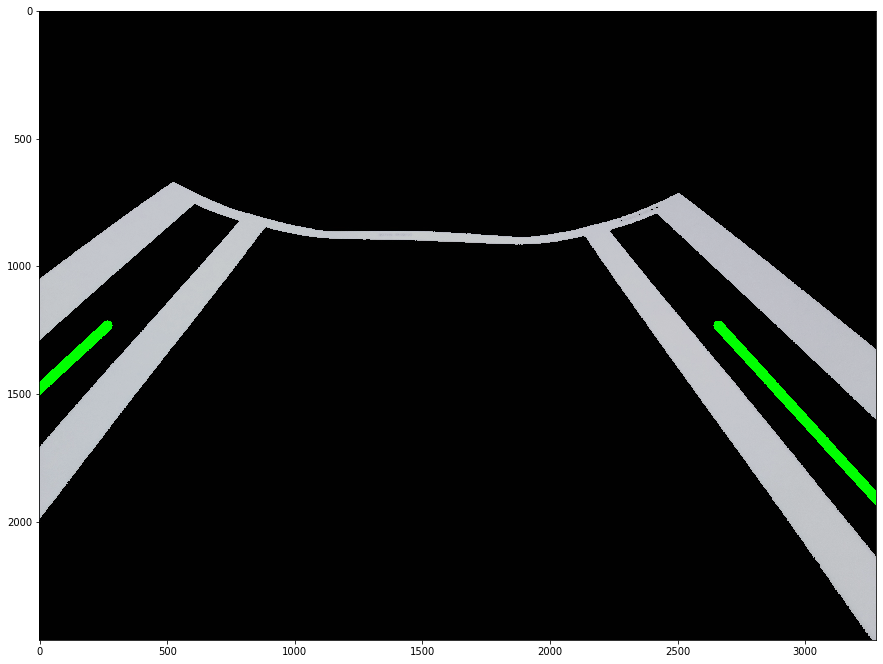

In [41]:
lane_lines = display_lines(img3,blah,line_width=40)
# cv2.imshow("lane lines", lane_lines)
plt.imshow(lane_lines)